In [1]:
#Motivation: https://github.com/rslim087a/PyTorch-for-Deep-Learning-and-Computer-Vision-Course-All-Codes-
import torch
import numpy as np
from torch import nn
from time import time
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [2]:
# Detect if a GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))
                               ])
training_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [4]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

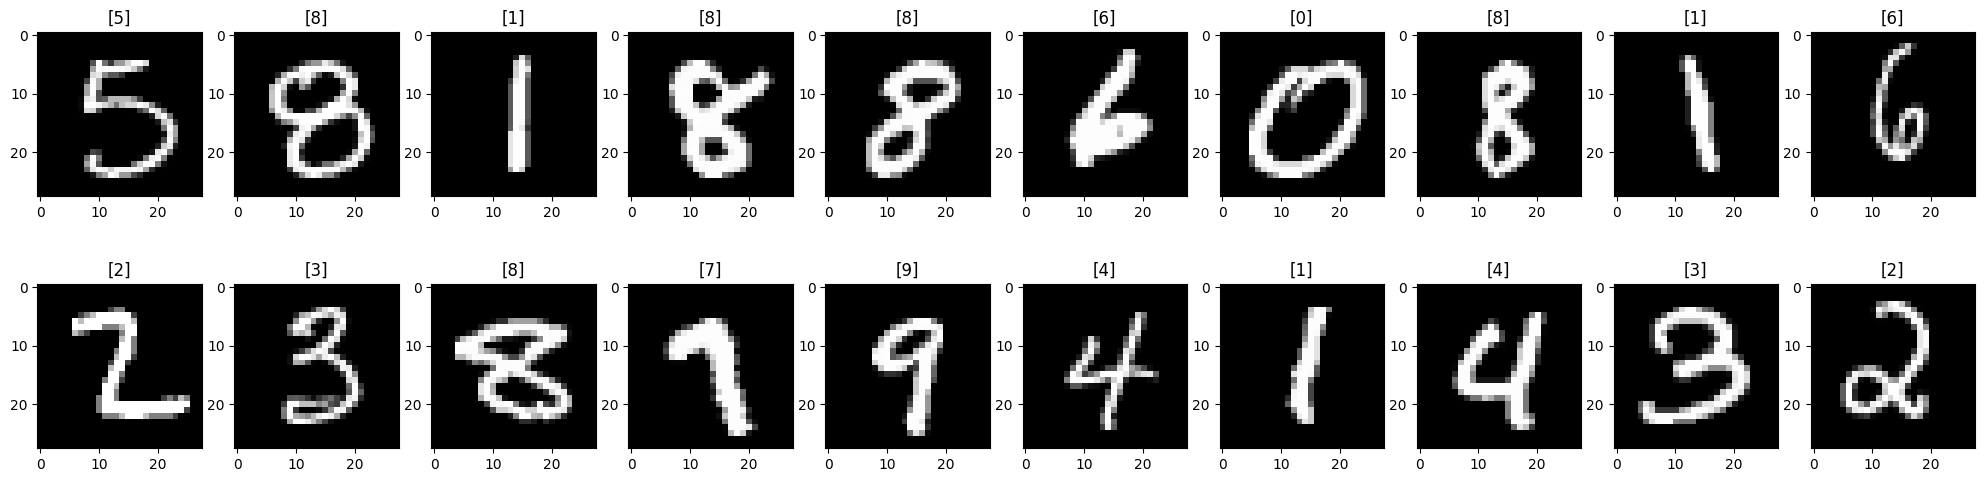

In [5]:
dataiter = iter(training_loader)
#images, labels = dataiter.next()
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 6))

for idx in range(20):
    ax = fig.add_subplot(2, 10, idx + 1)
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 24, 5, 1)
        self.conv2 = nn.Conv2d(24, 48, 5, 1)
        # How do we get (4*4*48)? - (28 - 5 + 1), (24/2), (12 - 5 + 1), (8/2)
        self.fc1 = nn.Linear(4*4*48, 96)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(96, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*48)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [7]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 24, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=768, out_features=96, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=96, out_features=10, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [9]:
epochs = 5
running_loss_history = []
running_correct_history = []
val_running_loss_history = []
val_running_correct_history = []

for epoch in range(epochs):
    
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    start_time = time()

    for inputs, labels in training_loader:
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        preds = preds.detach()
        preds = preds.cpu()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_outputs = model(val_inputs.to(device))
                val_loss = criterion(val_outputs, val_labels.to(device))
                
                _, val_preds = torch.max(val_outputs, 1)
                val_preds = val_preds.detach()
                val_preds = val_preds.cpu()
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
        
        epoch_loss = running_loss / len(training_loader)
        epoch_acc = running_corrects.float() / len(training_loader)
        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_acc = val_running_corrects.float() / len(validation_loader)

        running_loss_history.append(epoch_loss)
        running_correct_history.append(epoch_acc)
        val_running_loss_history.append(val_epoch_loss)
        val_running_correct_history.append(val_epoch_acc)

        end_time = time()
        print("epoch: ", epoch + 1)
        print("time: {:.2f} seconds".format(end_time - start_time))
        print("training loss: {:.4f}, training accuracy: {:.4f}".format(epoch_loss, epoch_acc.item()))
        print("validation loss: {:.4f}, validation accuracy: {:.4f}".format(val_epoch_loss, val_epoch_acc.item()))

epoch:  1
time: 42.45 seconds
training loss: 0.8705, training accuracy: 74.3917
validation loss: 0.3206, validation accuracy: 90.5600
epoch:  2
time: 42.33 seconds
training loss: 0.2636, training accuracy: 92.3250
validation loss: 0.1968, validation accuracy: 94.1800
epoch:  3
time: 40.98 seconds
training loss: 0.1778, training accuracy: 94.8383
validation loss: 0.1466, validation accuracy: 95.7100
epoch:  4
time: 41.25 seconds
training loss: 0.1396, training accuracy: 95.9700
validation loss: 0.1201, validation accuracy: 96.5300
epoch:  5
time: 49.81 seconds
training loss: 0.1191, training accuracy: 96.6333
validation loss: 0.0984, validation accuracy: 97.1000


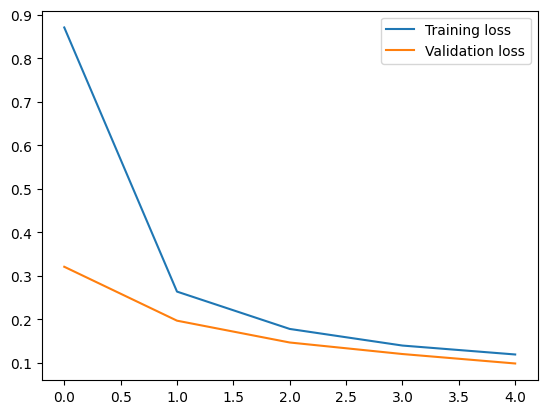

In [10]:
plt.plot(running_loss_history, label='Training loss')
plt.plot(val_running_loss_history, label='Validation loss')
plt.legend()

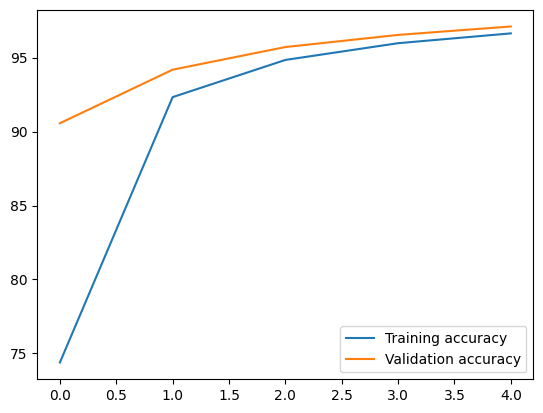

In [11]:
plt.plot(running_correct_history, label='Training accuracy')
plt.plot(val_running_correct_history, label='Validation accuracy')
plt.legend()

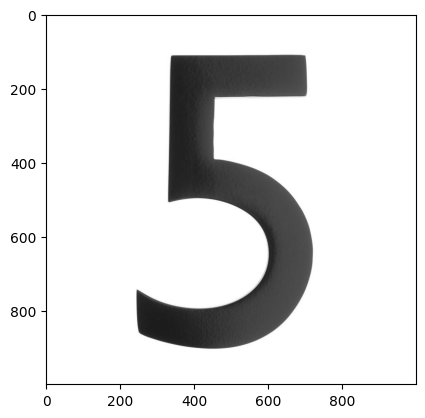

In [12]:
import requests
from PIL import Image

url = 'http://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

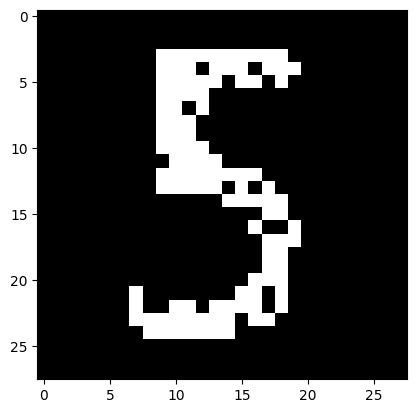

In [13]:
import PIL.ImageOps
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(im_convert(img))

In [14]:
img = img[0].unsqueeze(0).unsqueeze(0)
output = model(img.to(device))
_, pred = torch.max(output, 1)
print(pred.item())

5


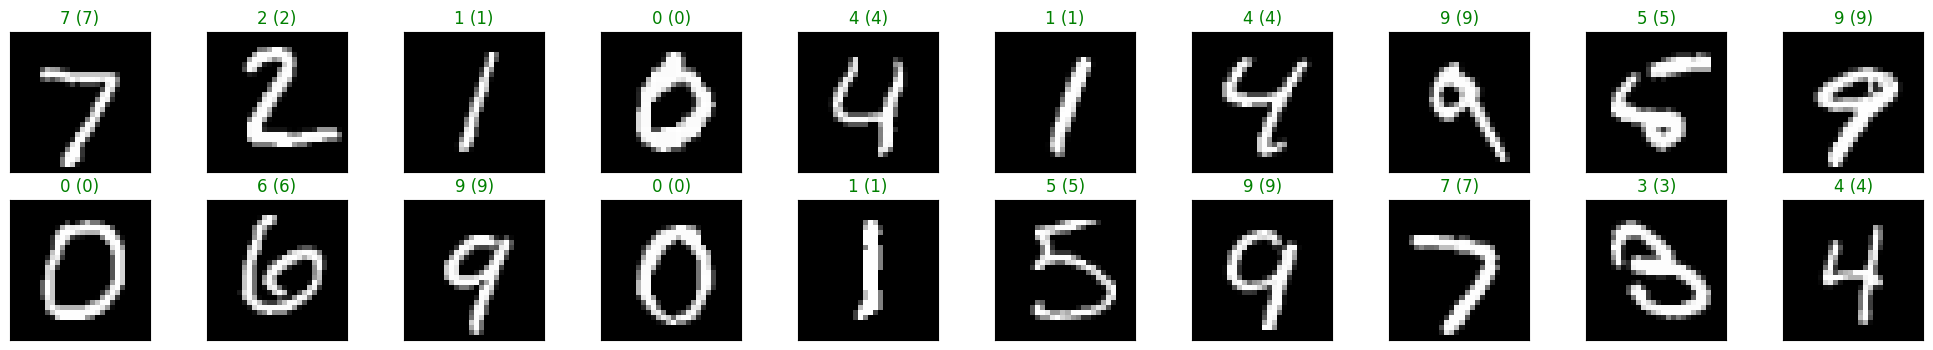

In [15]:
dataiter = iter(validation_loader)
images_, labels = next(dataiter)
output = model(images_.to(device))
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images_[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))